# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from imblearn.over_sampling import SMOTE

# Loading Data

In [2]:
#load data from EDA 
df= pd.read_csv('project2_df.csv')

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,...,year_weather,week,Species_virus,7day_Tavg,10day_Tavg,7day_Precip,10day_Precip,tavg_celsius,wetbulb_celsius,relative_humidity
0,0,0,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
1,1,1,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
2,2,2,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
3,3,3,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
4,4,4,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166


# Prepare the data for train- test-split

In [4]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Station', 'Date', 'Tmax', 'Tmin', 'Tavg',
       'DewPoint', 'WetBulb', 'CodeSum', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'year_train',
       'month_train', 'day_train', 'Address', 'Species', 'Trap', 'Latitude',
       'Longitude', 'NumMosquitos', 'WnvPresent', 'day_weather',
       'month_weather', 'year_weather', 'week', 'Species_virus', '7day_Tavg',
       '10day_Tavg', '7day_Precip', '10day_Precip', 'tavg_celsius',
       'wetbulb_celsius', 'relative_humidity'],
      dtype='object')

In [5]:
#dropping year, month, day from the train dataset
#dropping address, CodeSum, Trap
#drop date object column, Species with the different types as have 'Species_virus' which is either
#mosquitoes that carry the virus or not. 

df1= df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'CodeSum', 'Address', 'Trap', 'year_train', 'month_train', 'day_train', 'Date', 'Species'], axis=1)

In [6]:
df1.shape

(10506, 28)

In [7]:
#create X, y to be used in the train-test-split arguments
X= df1.drop('WnvPresent', axis=1)
y= df1['WnvPresent']

In [8]:
#Resample the minority using SMOTE package
smote = SMOTE()
X, y = smote.fit_resample(X, y)

0    9955
1    9955
Name: WnvPresent, dtype: int64


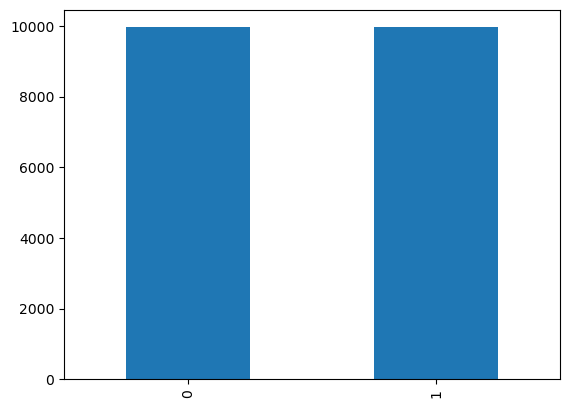

In [9]:
#graphing y value counts to make sure even amount of WnvPresent and not
y.value_counts().plot(kind='bar')
print(y.value_counts())

In [10]:
#split the data to prepare it for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [11]:
#check to make sure X, y similar lengths
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13937, 27) (5973, 27)
(13937,) (5973,)


In [12]:
#checking dtypes of X data
X_train.dtypes

Station                int64
Tmax                   int64
Tmin                   int64
Tavg                   int64
DewPoint               int64
WetBulb                int64
PrecipTotal          float64
StnPressure          float64
SeaLevel             float64
ResultSpeed          float64
ResultDir              int64
AvgSpeed             float64
Latitude             float64
Longitude            float64
NumMosquitos           int64
day_weather            int64
month_weather          int64
year_weather           int64
week                   int64
Species_virus          int64
7day_Tavg            float64
10day_Tavg           float64
7day_Precip          float64
10day_Precip         float64
tavg_celsius         float64
wetbulb_celsius      float64
relative_humidity    float64
dtype: object

# Modeling 

# Base Model - XGBoost

In [13]:
#setting the base model for XGBoost
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

#use model to predict y values on X_test set
y_pred = xgb_classifier.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.9573


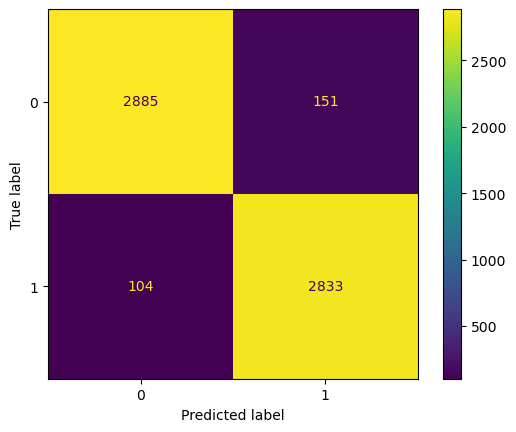

In [14]:
#display confustion matrix for base model of XGBoost
cm = confusion_matrix(y_test, y_pred, labels=xgb_classifier.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [15]:
#printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3036
           1       0.95      0.96      0.96      2937

    accuracy                           0.96      5973
   macro avg       0.96      0.96      0.96      5973
weighted avg       0.96      0.96      0.96      5973



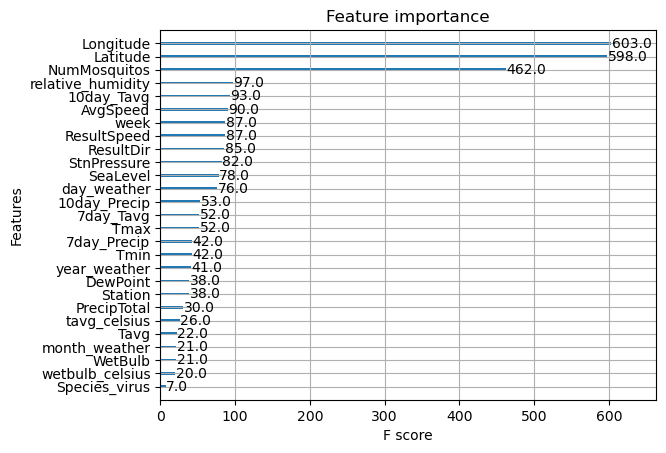

In [16]:
#plot important features from the base model
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

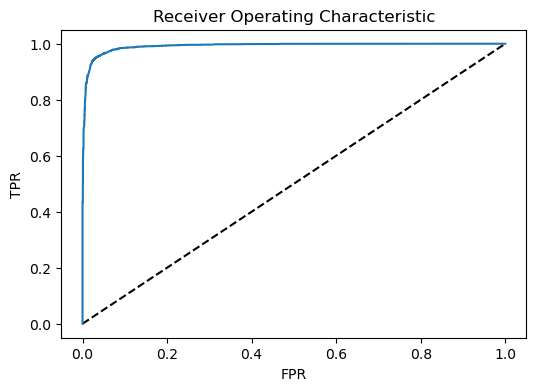

In [17]:
y_pred_prob1 = xgb_classifier.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Base Model")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

# Changing one parameter on base model: learning rate

In [18]:
# using a range of values for learning rate to see how XGBoost model changes
learning_rate_range = np.arange(0.01, 1, 0.05)
train_XG = []
test_XG = [] 

for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train)
    train_XG.append(xgb_classifier.score(X_train, y_train))
    test_XG.append(xgb_classifier.score(X_test, y_test))

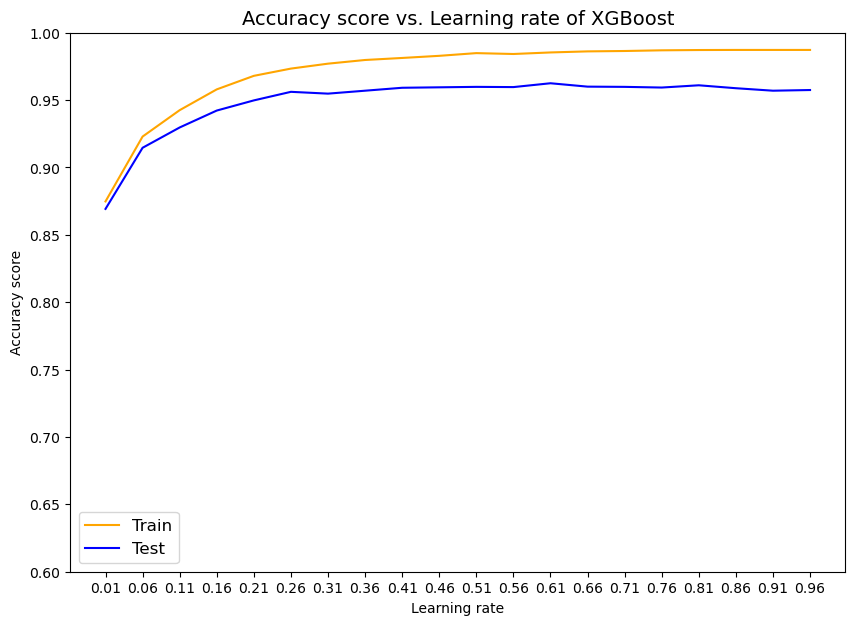

In [19]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='blue', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

# Setting XGBoost parameters to set numbers

In [20]:
# set parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 8,
            'learning_rate': .6,
            'n_estimators':200,
            'colsample_bytree': 0.5
        }

                     
# create model with set parameters 
xgb_model = XGBClassifier(**params)

# fit the classifier to the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBoost model accuracy score: 0.9593


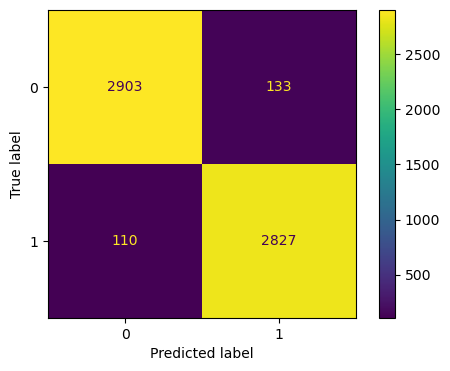

In [21]:
#predict y values from X_test set
y_pred = xgb_model.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)

#show confustion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot()
plt.show()

In [22]:
#printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3036
           1       0.96      0.96      0.96      2937

    accuracy                           0.96      5973
   macro avg       0.96      0.96      0.96      5973
weighted avg       0.96      0.96      0.96      5973



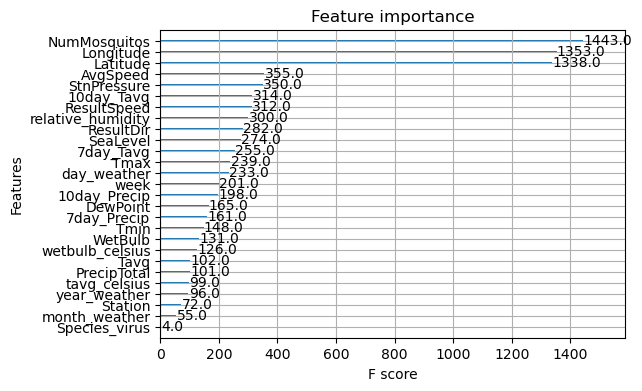

In [23]:
#plotting feature importance
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

See how location and number of mosquitoes seem to be a big predictor of this model.

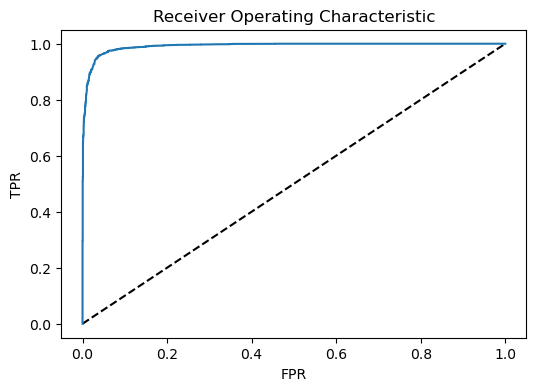

In [24]:
y_pred_prob1 = xgb_classifier.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "XGBoost with set parameters")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

# Grid Search for XGBoost

In [28]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [29]:
parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(120, 220, 40),
    'learning_rate': [0.2, 0.4, 0.6],  
    'min_child_weight' : range(2, 7, 1),
    'colsample_bytree': [0.2, 0.5]
}


In [30]:
#grid search with the different parameters listed above 5 cross validations
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [31]:
#fit the grid search on the X_train and y_train data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.2, 0.5],
                         'learning_rate': [0.2, 0.4, 0.6],
                         'max_depth': range(2, 10, 2),
                         'min_child_weight': range(2, 7),
                         'n_estimators': range(120, 220, 40)},
             scoring='roc_auc', verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)


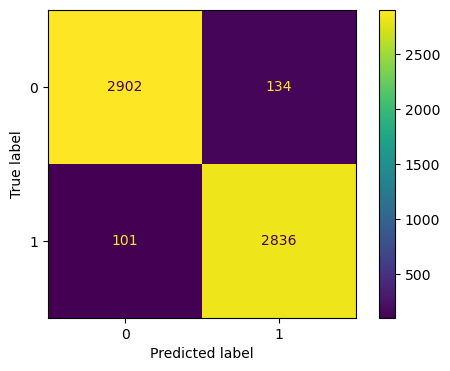

In [32]:
#using model above to predict y values using the X_test set
y_pred = grid_search.predict(X_test)

#print the best parameters from the grid search
print(grid_search.best_estimator_)

#display the confustion matrix from grid search
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.show()

In [33]:
#printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3036
           1       0.95      0.97      0.96      2937

    accuracy                           0.96      5973
   macro avg       0.96      0.96      0.96      5973
weighted avg       0.96      0.96      0.96      5973



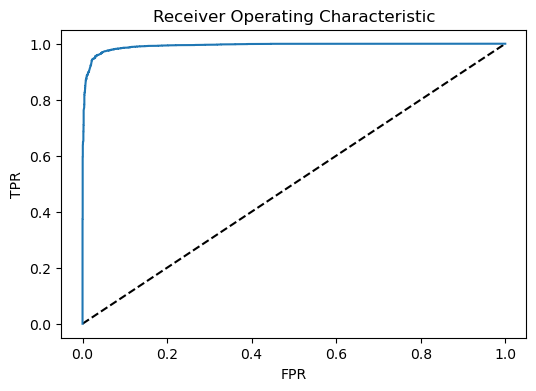

In [34]:
#ROC curve for XGBoost with hyperopt
y_pred_prob1 = grid_search.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "XGBoost with Grid Search")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

# XGBoost and Hyperopt 

In [40]:
#create the objective function
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(X_train, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }
#define the space 
space = {
    'max_depth' : hp.choice('max_depth', range(1, 14, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.9, 0.04),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 10)),
    'gamma' : hp.quniform('gamma', 0, 0.40, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 2),
    'subsample' : hp.quniform('subsample', 0.01, 1, 0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.1)}


#determine best model using the fmin function
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)

CrossValMean:                                                                   
0.9191376023383985                                                              
CrossValMean:                                                                   
0.9329854849158685                                                              
CrossValMean:                                                                   
0.9349227692057337                                                              
CrossValMean:                                                                   
0.9220071972899959                                                              
CrossValMean:                                                                   
0.9233704904930473                                                              
CrossValMean:                                                                   
0.9375775681028632                                                              
CrossValMean:               

In [41]:
# Using the best parameters found from the hyperopt model 
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )
#fitting the model on the training data
classifier.fit(X_train, y_train)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

Final CrossValMean:  0.9316221917128171


XGBoost model accuracy score: 0.9379


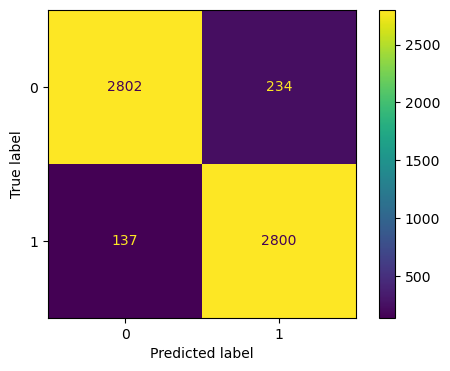

In [42]:
#find the predicted y values from using the X_test data
y_pred = classifier.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

Top left quadrant = True Positives = Number of mosquitoes NOT carrying West Nile virus
Bottom right quadrant = True Negatives = Number of mosquitoes carrying West Nile virus
Top right quadrant = False Positives = Number of mosquitoes that are not carrying virus labeled as carrying virus 
Bottom left quadrant = False Negatives = Number of mosquitoes carrying virus labeled as NOT carrying virus 

In [43]:
#printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3036
           1       0.92      0.95      0.94      2937

    accuracy                           0.94      5973
   macro avg       0.94      0.94      0.94      5973
weighted avg       0.94      0.94      0.94      5973



In [44]:
#printing the accuracy score from best hyperopt model with XGBoost
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.9379


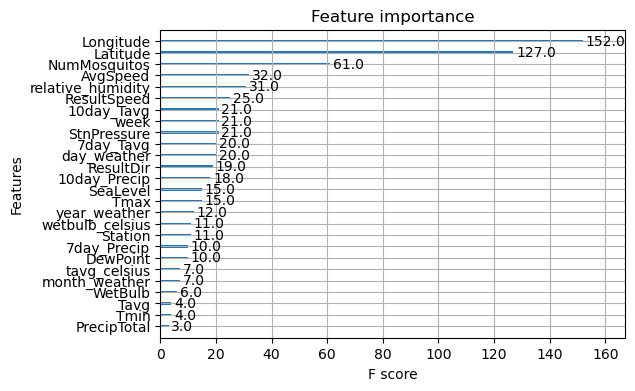

In [45]:
#plotting the feature importance from model
xgb.plot_importance(classifier)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

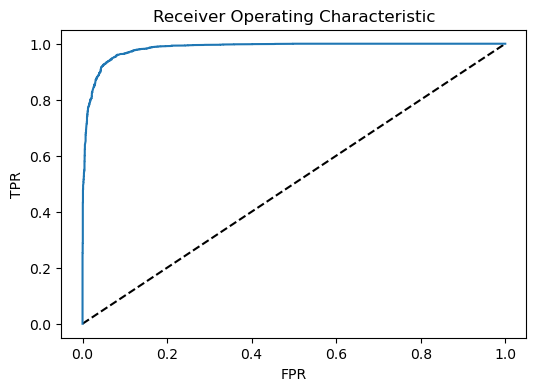

In [46]:
#ROC curve for XGBoost with hyperopt
y_pred_prob1 = classifier.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "XGBoost with Hyperopt")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

# Base Model for Random Forest 

In [47]:
from sklearn.ensemble import RandomForestClassifier 

In [48]:
clf = RandomForestClassifier(n_estimators = 100)   
  
# Train the model
clf.fit(X_train, y_train) 
  
# Make y predictions on the X_test data
y_pred = clf.predict(X_test) 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred)) 

ACCURACY OF THE MODEL:  0.9504436631508455


In [49]:
#use Grid search on Random Forest model
param_grid = { 
    'n_estimators': [50, 100, 150, 200], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [4, 8, 12], 
    'max_leaf_nodes': [4, 8, 12], 
} 

In [50]:
#train model on different parameters using grid search to find a better model
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=8, max_leaf_nodes=12, n_estimators=150)


In [51]:
#use best parameters from GridSearch above
model_grid = RandomForestClassifier(max_depth=12,
                                    max_features=None, 
                                    max_leaf_nodes=12, 
                                    n_estimators=50) 
model_grid.fit(X_train, y_train) 

RandomForestClassifier(max_depth=12, max_features=None, max_leaf_nodes=12,
                       n_estimators=50)

XGBoost model accuracy score: 0.9379


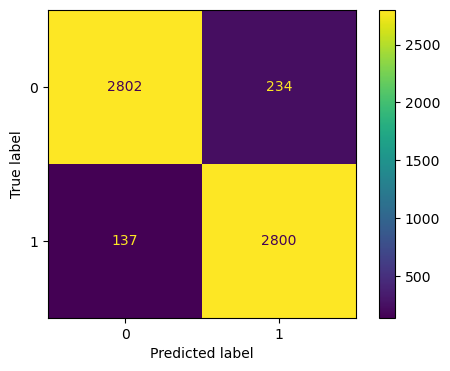

In [52]:
#find the predicted y values from using the X_test data
y_pred = classifier.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [53]:
#print classification report
print(classification_report(y_pred, y_test)) 

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2939
           1       0.95      0.92      0.94      3034

    accuracy                           0.94      5973
   macro avg       0.94      0.94      0.94      5973
weighted avg       0.94      0.94      0.94      5973



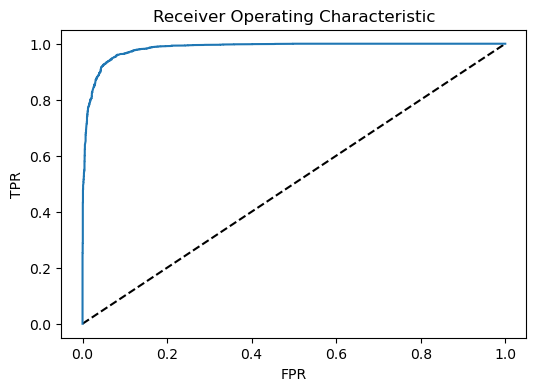

In [54]:
#ROC curve for XGBoost with hyperopt
y_pred_prob1 = classifier.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "XGBoost with Hyperopt")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

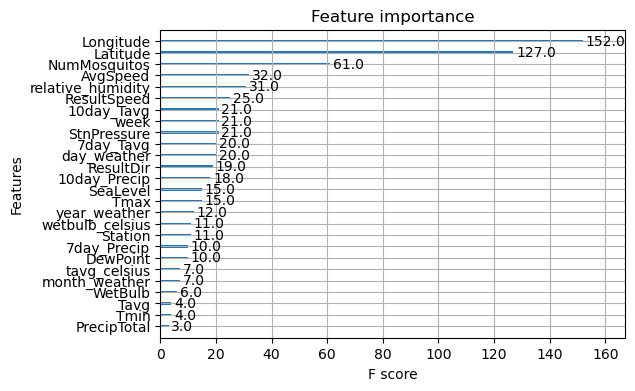

In [55]:
#plotting the feature importance from model
xgb.plot_importance(classifier)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()